This file contains the code to MAIR assignment 1a

# Read data

In [1]:
with open("dialog_acts.dat", 'r') as file:
    data = {'label': [], 'sentence': [], 'prediction': []}
    
    for line in file:
        words = line.split(maxsplit=1)
        if len(words) > 1:
            data['label'].append(words[0])
            data['sentence'].append(words[1])
        else:
            data['label'].append(words[0])
            data['sentence'].append('')

# inform Baseline

In [2]:
for sentence in data["sentence"]:
    data["prediction"].append("inform")

In [3]:
if len(data['label']) != len(data['prediction']):
    print("Error: The number of labels and predictions do not match.")
else:
    correct = 0
    total = len(data['label'])

    for i in range(total):
        if data['label'][i] == data['prediction'][i]:
            correct += 1

    accuracy = correct / total * 100
    print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 39.84%


# Rule based baseline

In [4]:
def count_labels(data):
    label_counts = {}

    # Count the occurrences of each label
    for label in data['label']:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

    # Print the count of each label
    for label, count in label_counts.items():
        print(f"{label}: {count}")

In [5]:
count_labels(data)

inform: 10160
confirm: 172
affirm: 1156
request: 6494
thankyou: 3259
null: 1612
bye: 266
reqalts: 1747
negate: 435
hello: 93
repeat: 33
ack: 28
restart: 14
deny: 27
reqmore: 5


In [6]:
keywords = {
    'ack': ['kay', 'okay'],
    'affirm': ['yes', 'right', 'yeah'],
    'thankyou': ['thank'],
    'bye': ['bye', 'goodbye'],
    'confirm': ['is it', 'does it', 'do they'],
    'deny': ['wrong', 'dont', 'not'],
    'hello': ['hi', 'hello', 'halo', 'welcome'],
    'inform': [
        'looking', 'restaurant', 'any', 'food', 'part', 'town', 'cheap', 'expensive', 
        'mediterranean', 'seafood', 'east', 'west', 'north', 'south', 'asian', 
        'oriental', 'scottish', 'matter', 'european', 'want', 'care', 'austrian', 
        'center', 'corsica', 'international', 'priced', 'moderately', 'moderate', 
        'central', 'eirtrean', 'spanish', 'venue', 'australian', 'turkish'
    ],
    'negate': ['no'],
    'null': [],
    'repeat': ['repeat', 'again', 'back'],
    'reqalts': ['how about', 'what about', 'is there', 'anything else'],
    'reqmore': ['more'],
    'request': ['address', 'phone', 'number', 'post code', 'how much', 'where', 'whats', 'what is', 'price range'],
    'restart': ['start', 'reset'],
}

In [7]:
def classify_sentence(sentence, keywords):
    # Convert the sentence to lowercase
    sentence_lower = sentence.lower()
    
    # Sort keywords by length in descending order to match longer phrases first
    sorted_keywords = sorted(((label, keyword) for label, kw_list in keywords.items() for keyword in kw_list),
                              key=lambda x: len(x[1]), reverse=True)
    
    # Check if any keyword is in the sentence
    for label, keyword in sorted_keywords:
        if keyword in sentence_lower:
            return label
    
    # Return 'null' if no keywords are found
    return 'null'

In [8]:
data['prediction'] = [classify_sentence(sentence, keywords) for sentence in data['sentence']]

In [9]:
def calculate_accuracy_filtered(labels, predictions):
    filtered_labels = []
    filtered_predictions = []
    
    for label, prediction in zip(labels, predictions):
        filtered_labels.append(label)
        filtered_predictions.append(prediction)
    
    if len(filtered_labels) != len(filtered_predictions):
        raise ValueError("Filtered labels and predictions lists must be of the same length.")
    
    correct = sum(1 for l, p in zip(filtered_labels, filtered_predictions) if l == p)
    total = len(filtered_labels)
    accuracy = (correct / total) * 100 if total > 0 else 0
    return accuracy

accuracy = calculate_accuracy_filtered(data['label'], data['prediction'])
print(accuracy)

81.48307909493745


In [10]:
from collections import defaultdict

def calculate_accuracy_per_label(labels, predictions):
    label_counts = defaultdict(int)  # To count occurrences of each label
    correct_counts = defaultdict(int)  # To count correct predictions for each label

    for label, prediction in zip(labels, predictions):
        label_counts[label] += 1
        if label == prediction:
            correct_counts[label] += 1

    accuracy_per_label = {}
    for label in label_counts:
        total = label_counts[label]
        correct = correct_counts[label]
        accuracy_per_label[label] = (correct / total) * 100 if total > 0 else 0
    
    return accuracy_per_label

accuracy_per_label = calculate_accuracy_per_label(data['label'], data['prediction'])

# Print or inspect the accuracy per label
for label, accuracy in accuracy_per_label.items():
    print(f"{label}, Accuracy: {accuracy:.2f}%")


inform, Accuracy: 79.60%
confirm, Accuracy: 51.16%
affirm, Accuracy: 80.62%
request, Accuracy: 88.10%
thankyou, Accuracy: 87.11%
null, Accuracy: 61.29%
bye, Accuracy: 74.44%
reqalts, Accuracy: 85.00%
negate, Accuracy: 70.11%
hello, Accuracy: 49.46%
repeat, Accuracy: 100.00%
ack, Accuracy: 60.71%
restart, Accuracy: 92.86%
deny, Accuracy: 81.48%
reqmore, Accuracy: 100.00%


In [11]:
def classify_sentence(sentence):
    for label, words in keywords.items():
        if any(word in sentence.lower() for word in words):
            return label
    return 'Unknown'  # Default label if no keywords are matched

In [12]:
def manual_test_model(classify_function):
    while True:
        sentence = input("Enter a sentence to classify (or type 'exit' to stop): ")
        
        if sentence.lower() == 'exit':
            print("Exiting the classifier.")
            break
        
        label = classify_function(sentence)
        print(f"Classified as: {label}")

In [13]:
manual_test_model(classify_sentence)

Enter a sentence to classify (or type 'exit' to stop):  exit


Exiting the classifier.


# Feed Forward Neural Network

In [14]:
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
# Convert all labels to numbers
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

In [16]:
max_words = 10000  # Maximum number of words
max_len = 128  # Maximum sentence length

In [17]:
def tokenize_data(data):
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(data['sentence'])
    sequences = tokenizer.texts_to_sequences(data['sentence'])
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences

In [18]:
padded_sequences = tokenize_data(data)

In [19]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    padded_sequences, data['label'], test_size=0.2, random_state=42
)

In [20]:
def create_model():
    model = models.Sequential()
    
    model.add(layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(15, activation='softmax'))  # 15 classes
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [21]:
model = create_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 128)          1280000   
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 256)               4194560   
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                                 
Total params: 5478415 (20.90 MB)
Trainable params: 5478415 (20.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
history = model.fit(train_sentences, train_labels, epochs=5, batch_size=16, validation_split=0.2)

Epoch 1/5


1020/1020 [==============================] - 32s 31ms/step - loss: 0.3089 - accuracy: 0.9143 - val_loss: 0.1043 - val_accuracy: 0.9696
Epoch 2/5
1020/1020 [==============================] - 31s 30ms/step - loss: 0.0739 - accuracy: 0.9800 - val_loss: 0.0852 - val_accuracy: 0.9770
Epoch 3/5
1020/1020 [==============================] - 31s 31ms/step - loss: 0.0421 - accuracy: 0.9877 - val_loss: 0.0859 - val_accuracy: 0.9757
Epoch 4/5
1020/1020 [==============================] - 31s 30ms/step - loss: 0.0273 - accuracy: 0.9915 - val_loss: 0.0931 - val_accuracy: 0.9775
Epoch 5/5
1020/1020 [==============================] - 32s 31ms/step - loss: 0.0180 - accuracy: 0.9942 - val_loss: 0.0872 - val_accuracy: 0.9804


In [23]:
def model_report(model, sentences):
    predictions = model.predict(test_sentences)
    predicted_labels = np.argmax(predictions, axis=1)
    
    all_classes = list(range(15))
    report = classification_report(test_labels, predicted_labels, labels=all_classes, target_names=[f'{le.inverse_transform([i])[0]}' for i in all_classes])
    print(report)

In [24]:
model_report(model, test_sentences)

160/160 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         ack       1.00      0.20      0.33         5
      affirm       0.99      0.99      0.99       247
         bye       0.93      0.89      0.91        46
     confirm       0.94      0.94      0.94        33
        deny       1.00      0.71      0.83         7
       hello       1.00      1.00      1.00        16
      inform       0.99      0.99      0.99      2041
      negate       1.00      0.99      0.99        81
        null       0.93      0.97      0.95       309
      repeat       1.00      0.75      0.86         4
     reqalts       0.97      0.95      0.96       368
     reqmore       0.67      1.00      0.80         2
     request       1.00      1.00      1.00      1305
     restart       1.00      0.33      0.50         3
    thankyou       0.99      1.00      0.99       634

    accuracy                           0.98      5101
   macro avg       0.96  

In [25]:
def confusion_matrix(sentences, labels):
    # Get the predictions for the test set
    y_pred = model.predict(sentences)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to predicted class labels
    y_true_labels = labels
    
    cm = sklearn_confusion_matrix(y_true_labels, y_pred_labels)
    
    class_names = le.inverse_transform(np.unique(y_true_labels))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

160/160 [==============================] - 1s 3ms/step


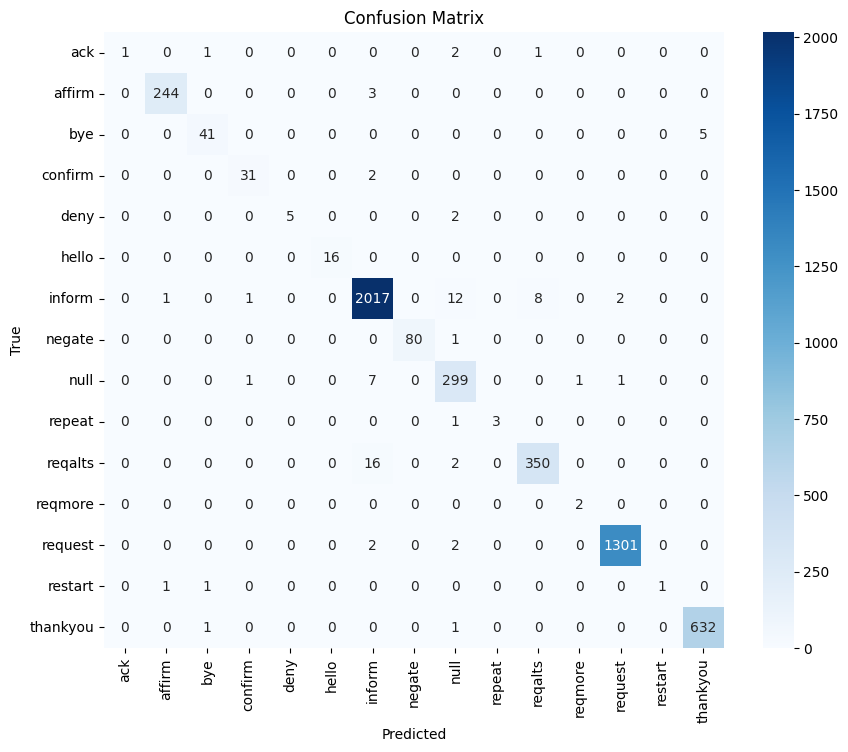

In [26]:
confusion_matrix(test_sentences, test_labels)

In [27]:
test_loss, test_acc = model.evaluate(test_sentences, test_labels)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

160/160 [==============================] - 1s 3ms/step - loss: 0.0603 - accuracy: 0.9847
Test Accuracy: 98.47%


In [28]:
unique_labels = sorted(list(set(data['label'])))

In [29]:
def classify_sentence_fnn(sentence):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=128, padding='post')
    
    prediction = model.predict(padded_sequence)
    
    predicted_label_index = np.argmax(prediction, axis=1)[0]
    predicted_label = le.inverse_transform([predicted_label_index])[0]

    return predicted_label

In [30]:
manual_test_model(classify_sentence_fnn)

Enter a sentence to classify (or type 'exit' to stop):  exit


Exiting the classifier.


### Deduplicate

In [31]:
df = pd.DataFrame(data)
df_cleaned = df.drop_duplicates(subset=['label', 'sentence'])
data_deduplicate = df_cleaned.to_dict(orient='list')
data_deduplicate['label'] = np.array(data_deduplicate['label'])

In [32]:
le_dedup = LabelEncoder()
data_deduplicate['label'] = le_dedup.fit_transform(data_deduplicate['label'])

In [33]:
print(len(data['sentence']))
print(len(data_deduplicate['sentence']))

25501
5359


In [34]:
padded_sequences_dedup = tokenize_data(data_deduplicate)

In [35]:
train_sentences_dedup, test_sentences_dedup, train_labels_dedup, test_labels_dedup = train_test_split(
    padded_sequences_dedup, data_deduplicate['label'], test_size=0.2, random_state=42
)

In [36]:
model_deduplicate = create_model()
history_deduplicate = model_deduplicate.fit(train_sentences_dedup, train_labels_dedup, epochs=5, batch_size=16, validation_split=0.2)

Epoch 1/5
215/215 [==============================] - 7s 31ms/step - loss: 0.9003 - accuracy: 0.7445 - val_loss: 0.5450 - val_accuracy: 0.8345
Epoch 2/5
215/215 [==============================] - 6s 30ms/step - loss: 0.3825 - accuracy: 0.8828 - val_loss: 0.4064 - val_accuracy: 0.8741
Epoch 3/5
215/215 [==============================] - 6s 30ms/step - loss: 0.2449 - accuracy: 0.9271 - val_loss: 0.3515 - val_accuracy: 0.8928
Epoch 4/5
215/215 [==============================] - 6s 30ms/step - loss: 0.1655 - accuracy: 0.9478 - val_loss: 0.3426 - val_accuracy: 0.9033
Epoch 5/5
215/215 [==============================] - 6s 30ms/step - loss: 0.1201 - accuracy: 0.9603 - val_loss: 0.3595 - val_accuracy: 0.9033


In [37]:
test_loss_deduplicate, test_acc_deduplicate = model_deduplicate.evaluate(test_sentences_dedup, test_labels_dedup)
print(f"Test Accuracy: {test_acc_deduplicate * 100:.2f}%")

34/34 [==============================] - 0s 3ms/step - loss: 0.2972 - accuracy: 0.9011
Test Accuracy: 90.11%


In [38]:
model_report(model_deduplicate, test_sentences_dedup)

160/160 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         5
      affirm       0.00      0.00      0.00       247
         bye       0.00      0.00      0.00        46
     confirm       0.00      0.00      0.00        33
        deny       0.00      0.00      0.00         7
       hello       0.00      0.00      0.00        16
      inform       0.36      0.50      0.42      2041
      negate       0.00      0.00      0.00        81
        null       0.11      0.35      0.17       309
      repeat       0.00      0.00      0.00         4
     reqalts       0.01      0.00      0.00       368
     reqmore       0.00      0.00      0.00         2
     request       0.33      0.23      0.27      1305
     restart       0.00      0.00      0.00         3
    thankyou       0.00      0.00      0.00       634

    accuracy                           0.28      5101
   macro avg       0.05  

C:\Users\storm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\storm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\storm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

34/34 [==============================] - 0s 3ms/step


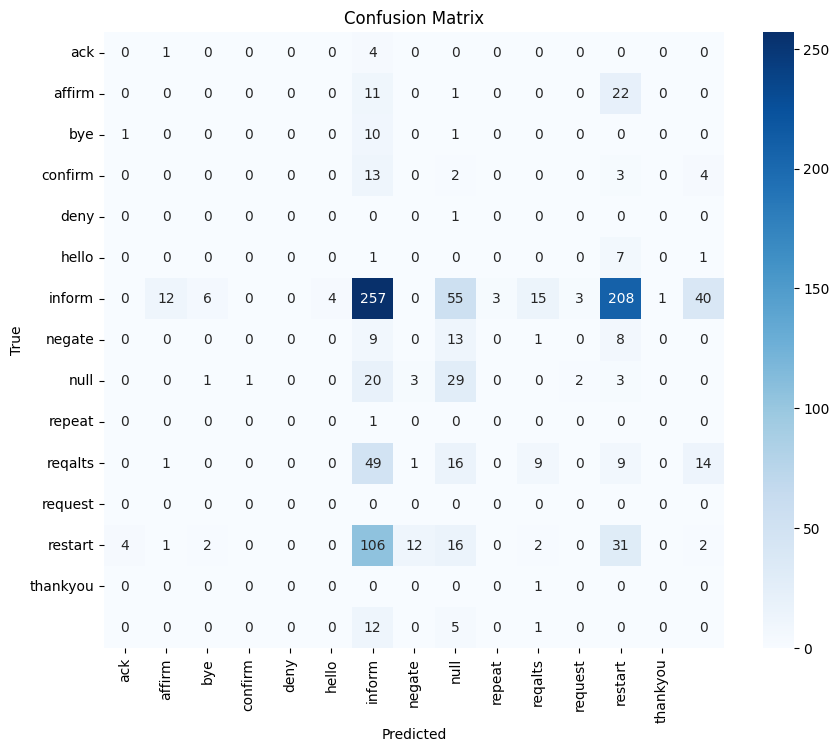

In [40]:
confusion_matrix(test_sentences_dedup, test_labels_dedup)

# Decision tree

In [41]:
# imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [42]:
data_path = "dialog_acts.dat"
def cargar_dataset(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # space split
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                dialog_act, utterance_content = parts
                data.append((dialog_act, utterance_content))
            else:
                print(f"Incorrect line: {line}")
    return data

data = cargar_dataset(data_path)

In [43]:
#convert text into Bag of Words representation
def preprocess_data(data):
    # sentence
    utterances = [utterance for _, utterance in data]

    # utterances into a Bag of Words representation
    vectorizer = CountVectorizer(lowercase=True)  # Remove stop_words
    X = vectorizer.fit_transform(utterances)  # Transform sentences into BoW
    return X, vectorizer

# Train the Decision Tree classifier
def train_decision_tree_classifier(X_train, y_train):
    # Adjusting hyperparameters to avoid overfitting and improve accuracy
    clf_tree = DecisionTreeClassifier(
        random_state=42,
        max_depth=20,  # Limits the depth of the tree
        min_samples_split=5,  # Minimum samples required to split an internal node
        criterion='entropy'  # Using entropy as the criterion (information gain)
    )
    clf_tree.fit(X_train, y_train)
    return clf_tree

# Evaluate the classifier's performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Decision Tree model accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))

# Interactive classification
def classify_sentence(model, vectorizer):
    while True:
        input_sentence = input("\nEnter a sentence (or 'exit' to quit): ")
        if input_sentence.lower() == 'exit':
            break
        input_bow = vectorizer.transform([input_sentence])
        prediction = model.predict(input_bow)
        print(f"The predicted dialog act is: {prediction[0]}")


In [44]:
# Extract the labels (dialog acts) from the tuples
labels = [dialog_act for dialog_act, _ in data]

# Step 2: Preprocess the data
X, vectorizer = preprocess_data(data)

# Split the data into training and testing sets (increased test size for better generalization)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.15, random_state=42)

# Step 3: Train the Decision Tree classifier
clf_tree = train_decision_tree_classifier(X_train, y_train)

# Step 4: Evaluate the model's performance
evaluate_model(clf_tree, X_test, y_test)

Decision Tree model accuracy: 0.95
              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         5
      affirm       0.99      0.94      0.97       180
         bye       0.97      0.89      0.93        35
     confirm       0.78      0.82      0.80        22
        deny       0.00      0.00      0.00         6
       hello       1.00      0.43      0.60        14
      inform       0.91      0.99      0.95      1532
      negate       1.00      1.00      1.00        69
        null       0.98      0.72      0.83       232
      repeat       0.00      0.00      0.00         3
     reqalts       0.97      0.93      0.95       279
     reqmore       0.00      0.00      0.00         1
     request       0.99      0.97      0.98       972
     restart       0.00      0.00      0.00         2
    thankyou       1.00      1.00      1.00       474

    accuracy                           0.95      3826
   macro avg       0.64      0.58      0.60  

C:\Users\storm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\storm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\storm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
# Interactive sentence classification
print("\nInteractive test with the Decision Tree model:")
classify_sentence(clf_tree, vectorizer)

In [46]:
# Accuracy - Training set
train_predictions = clf_tree.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

# Accuracy - Test set
test_predictions = clf_tree.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9522029988465974
Test Accuracy: 0.9545216936748563


# CVM

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import matplotlib
matplotlib.use('TkAgg')

In [48]:
# Process files: read and classify line by line
def process_file(filepath):
    labeled_lines = []
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            lines = file.readlines()

        for line in lines:
            # Ensure that line contains both label and sentence
            if len(line.strip().split(" ", 1)) == 2:
                # Extract original label and sentence
                original_label, sentence = line.split(" ", 1)
                original_label = original_label.strip()
                sentence = sentence.strip()

                # Store original label and sentence
                labeled_lines.append((original_label, sentence))
            else:
                print(f"Line skipped due to incorrect format: {line.strip()}")

    except FileNotFoundError:
        print(f"File not found: {filepath}")
    except Exception as e:
        print(f"Error while processing file: {e}")

    return labeled_lines

In [49]:
# Function to remove duplicates
def remove_duplicates(labeled_lines):
    seen_sentences = set()
    deduplicated_lines = []

    for label, sentence in labeled_lines:
        if sentence not in seen_sentences:
            deduplicated_lines.append((label, sentence))
            seen_sentences.add(sentence)

    return deduplicated_lines

In [50]:
def save_deduplicated_data(input_file, output_file):
    labeled_lines = process_file(input_file) 
    deduplicated_lines = remove_duplicates(labeled_lines) 


    with open(output_file, 'w', encoding='utf-8') as file:
        for label, sentence in deduplicated_lines:
            file.write(f"{label} {sentence}\n")

    print(f"Deduplicated data saved to {output_file}")

In [51]:
save_deduplicated_data('dialog_acts.dat', 'deduplicated_data.txt')

Deduplicated data saved to deduplicated_data.txt


In [52]:
def plot_class_distribution_comparison(original_data, deduplicated_data):
    # Convert data to DataFrames
    df_original = pd.DataFrame(original_data, columns=['label', 'sentence'])
    df_deduplicated = pd.DataFrame(deduplicated_data, columns=['label', 'sentence'])

    # Calculate class distribution for each type
    original_distribution = df_original['label'].value_counts().sort_index()
    deduplicated_distribution = df_deduplicated['label'].value_counts().sort_index()

    # Combine into a single DataFrame
    comparison_df = pd.DataFrame({
        'Original Data': original_distribution,
        'Deduplicated Data': deduplicated_distribution
    }).fillna(0)

    # Plotting
    ax = comparison_df.plot(kind='bar', figsize=(14, 8), width=0.8)
    plt.title('Class Distribution Comparison')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [53]:
original_data = process_file('dialog_acts.dat')
deduplicated_data = process_file('deduplicated_data.txt')  # Ensure this file exists and contains deduplicated data

In [54]:
plot_class_distribution_comparison(original_data, deduplicated_data)

In [55]:
# Function to train and evaluate the model, and save results to a file
def train_and_evaluate(labeled_lines, description, output_file):
    # Extract sentences and labels
    sentences = [sentence for _, sentence in labeled_lines]
    labels = [label for label, _ in labeled_lines]

    # Convert text data into TF-IDF features
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.15, random_state=42)

    # Train SVM classifier
    svm_classifier = SVC(C=1.0, kernel='linear')  # Using linear kernel for simplicity
    svm_classifier.fit(X_train, y_train)

    # Predict labels for testing data
    y_pred = svm_classifier.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{description} Accuracy: {accuracy * 100:.2f}%")

    # Calculate confusion matrix and classification report
    cm = sklearn_confusion_matrix(y_test, y_pred, labels=svm_classifier.classes_)
    labels = svm_classifier.classes_  # Use the labels from the classifier
    report = classification_report(y_test, y_pred, labels=labels, target_names=labels, output_dict=True, zero_division=0)

    # Save the test results to a file
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write("Original Label\tPredicted Label\tSentence\n")
        for original_label, predicted_label, sentence in zip(y_test, y_pred, [sentences[i] for i in X_test.indices]):
            f.write(f"{original_label}\t{predicted_label}\t{sentence}\n")

    print(f"{description} results saved to {output_file}")

    return cm, report, labels

In [56]:
# Get results for original data
cm_orig, report_orig, classes_orig = train_and_evaluate(original_data, "Original Data","original_data_results.txt")

# Get results for deduplicated data
cm_dedup, report_dedup, classes_dedup = train_and_evaluate(deduplicated_data, "Deduplicated Data", "deduplicated_data_results.txt")

# Ensure that classes are the same for both
assert (classes_orig == classes_dedup).all(), "Class labels should be the same for both datasets."

Original Data Accuracy: 98.35%
Original Data results saved to original_data_results.txt
Deduplicated Data Accuracy: 90.80%
Deduplicated Data results saved to deduplicated_data_results.txt


In [57]:
def plot_confusion_matrices_and_reports(cm_orig, cm_dedup, report_orig, report_dedup, classes):
    # Prepare classification reports
    df_report_orig = pd.DataFrame(report_orig).T
    df_report_dedup = pd.DataFrame(report_dedup).T

    # Remove 'support' column from reports for a cleaner view
    df_report_orig = df_report_orig.drop(columns='support')
    df_report_dedup = df_report_dedup.drop(columns='support')

    # Plot confusion matrices
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix - Original Data')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(2, 2, 2)
    sns.heatmap(cm_dedup, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix - Deduplicated Data')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot classification reports
    plt.subplot(2, 2, 3)
    sns.heatmap(df_report_orig, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Classification Report - Original Data')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 4)
    sns.heatmap(df_report_dedup, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Classification Report - Deduplicated Data')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [58]:
# Plot the results
plot_confusion_matrices_and_reports(cm_orig, cm_dedup, report_orig, report_dedup, classes_orig)

# Process files and create two datasets
filepath = "dialog_acts.dat"  # File path containing original labels and sentences
labeled_output = process_file(filepath)

if labeled_output:
    # Train and evaluate with original data and save results
    train_and_evaluate(labeled_output, "Original Data", "original_data_results.txt")

    # Remove duplicates
    deduplicated_output = remove_duplicates(labeled_output)

    # Train and evaluate with deduplicated data and save results
    train_and_evaluate(deduplicated_output, "Deduplicated Data", "deduplicated_data_results.txt")
else:
    print("No data to process.")

Original Data Accuracy: 98.35%
Original Data results saved to original_data_results.txt
Deduplicated Data Accuracy: 90.80%
Deduplicated Data results saved to deduplicated_data_results.txt
